Below, I install my own implementation of Professor Boonstra's "memoize DataFrame to disk" feature. The source code can be found at [github.com/ethho/memoize](https://github.com/ethho/memoize).

In [1]:
!python3 -m pip install git+https://github.com/ethho/memoize.git

  Cloning https://github.com/ethho/memoize.git to /tmp/pip-req-build-85fx1yn1
  Running command git clone --filter=blob:none --quiet https://github.com/ethho/memoize.git /tmp/pip-req-build-85fx1yn1
  Resolved https://github.com/ethho/memoize.git to commit bef633bd22e4acde44cccb63399a176c6cef79b9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import json
import re
import os
from glob import glob
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import quandl
import functools
import plotly.express as px
import plotly.graph_objects as go
from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Pool
from src.ubacktester import (
    BacktestEngine, StrategyBase, PositionBase, FeedBase,
    PlotlyPlotter, FeedID, PriceFeed, px_plot, ClockBase
)
from memoize.dataframe import memoize_df

%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

# 20230210_hw5_ho_ethan_12350006

@mpcs
@finm33550

Ethan Ho 2/10/2023

----

## Configuration & Helper Functions

The following cell contains helper functions and configuration options that I will use in this notebook.

In [46]:
def get_secrets(fp='./secrets.json'):
    """
    Reads secret values such as API keys from a JSON-formatted file at `fp`.
    """
    with open(fp, 'r') as f:
        data = json.load(f)
    return data

def get_quandl_api_key() -> str:
    """
    Returns Quandl API key stored in secrets.json.
    """
    secrets = get_secrets()
    key = secrets.get('NASTAQ_DATA_API_KEY')
    assert key, f"NASTAQ_DATA_API_KEY field in secrets.json is empty or does not exist"
    return key

def strip_str_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame, strips values in columns with string or object
    dtype. I noticed that this was an issue when I saw some m_ticker values
    like "AAPL       " with trailing whitespace.
    """
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
            df[col] = df[col].str.strip()
    return df

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_table(
    name, start_date, end_date, **kw
) -> pd.DataFrame:
    df = quandl.get_table(
        name,
        date={'gte': start_date, 'lte': end_date},
        api_key=get_quandl_api_key(),
        paginate=True,
        **kw
    )
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    df.reset_index(inplace=True)
    return df

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_quotemedia_prices(
    start_date, end_date, ticker
) -> pd.DataFrame:
    return fetch_quandl_table(
        name= 'QUOTEMEDIA/PRICES',
        start_date=start_date,
        end_date=end_date,
        ticker=ticker,
    )

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_yc(
    name, start_date, end_date,
) -> pd.DataFrame:
    df = quandl.get(
        name,
        start_date=start_date,
        end_date=end_date,
        api_key=get_quandl_api_key(),
    ).reset_index().rename(columns={'Date': 'date'})
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    return df

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_spot(
    symbol, **kw
) -> pd.DataFrame:
    df = quandl.get(
        f'CUR/{symbol}',
        **kw
    ).reset_index().rename(columns={
        'DATE': 'date',
        'RATE': f'USD/{symbol}',
    })
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    return df

def unique_index_keys(df, level=0) -> List[str]:
    return df.index.get_level_values(level=level).unique().tolist()

def get_next_day_of_week(date, day_of_week: int) -> str:
    """
    Monday = 0, Wednesday = 2
    """
    as_dt = pd.to_datetime(date)
    days_until = (day_of_week - as_dt.day_of_week) % 7
    out_dt = as_dt + pd.to_timedelta(days_until, 'D')
    return out_dt.strftime('%Y-%m-%d')

# Fetch Data

First, let's set our time indices. We choose to trade weekly on Wednesdays, and skip the week if the Wednesday falls on a holiday.

In [83]:
start_date = '2009-01-01'
end_date = '2022-12-16'

daily_idx = pd.date_range(start_date, end_date)
first_wed = get_next_day_of_week(start_date, 2)
wed_idx_w_holidays = pd.date_range(first_wed, end_date, freq='7D')
assert all(date.day_of_week == 2 for date in wed_idx_w_holidays)

wed_idx = [
    date for date in wed_idx_w_holidays
    if date not in pd.to_datetime([
        # Remove Wednesdays that fall on holidays
        '2012-12-26', '2013-12-25', '2014-01-01', '2018-12-26',
        '2019-12-25', '2020-01-01',
    ])
]
assert len(wed_idx_w_holidays) > len(wed_idx)

Now, we fetch UK OIS rates and FX spot rates:

In [135]:
def get_standard_yc_cols(cols: List, col_prefix='') -> Dict:
    out = dict()
    for col_raw in cols:
        col = col_raw.lower()
        col = re.sub(r'-year', 'y', col)
        col = re.sub(r'-month', 'm', col)
        if col_prefix:
            col = col_prefix + '_' + col
        out[col_raw] = col
    return out

In [136]:
def get_yc(*args, col_prefix='', **kw):
    df = fetch_quandl_yc(*args, **kw)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    df.rename(columns=get_standard_yc_cols(df.columns, col_prefix), inplace=True)
    return df

ois_daily = pd.concat([
    get_yc('YC/GBR_ISSC', start_date=start_date, end_date='2021-12-09', col_prefix='gbr'),
    get_yc('YC/GBR_ISSS', start_date='2021-12-10', end_date=end_date, col_prefix='gbr'),
], axis=0)
assert not ois_daily.isnull().any().any()
ois = ois_daily.loc[wed_idx]
ois_daily

Using cache fp='data/memoize/fetch_quandl_yc_25bceb9_20230209.csv' to write results of function fetch_quandl_yc
Using cached call from data/memoize/fetch_quandl_yc_25bceb9_20230209.csv
Using cache fp='data/memoize/fetch_quandl_yc_28c3f08_20230209.csv' to write results of function fetch_quandl_yc
Using cached call from data/memoize/fetch_quandl_yc_28c3f08_20230209.csv


,gbr_0.08y,gbr_0.17y,gbr_0.25y,gbr_0.33y,gbr_0.42y,gbr_0.5y,gbr_0.58y,gbr_0.67y,gbr_0.75y,gbr_0.83y,...,gbr_4.25y,gbr_4.33y,gbr_4.42y,gbr_4.5y,gbr_4.58y,gbr_4.67y,gbr_4.75y,gbr_4.83y,gbr_4.92y,gbr_5.0y
date,,,,,,,,,,,,,,,,,,,,,
2009-01-02,1.2797,1.1715,1.0801,1.0080,0.9538,0.9151,0.8891,0.8739,0.8680,0.8709,...,2.2952,2.3146,2.3333,2.3515,2.3691,2.3861,2.4027,2.4187,2.4343,2.4494
2009-01-05,1.2046,1.1085,1.0283,0.9672,0.9231,0.8932,0.8751,0.8666,0.8665,0.8740,...,2.3555,2.3757,2.3954,2.4144,2.4329,2.4508,2.4681,2.4850,2.5014,2.5174
2009-01-06,1.1738,1.0838,1.0121,0.9615,0.9282,0.9082,0.8984,0.8973,0.9034,0.9161,...,2.3763,2.3970,2.4171,2.4366,2.4556,2.4741,2.4920,2.5096,2.5266,2.5433
2009-01-07,1.1134,1.0287,0.9626,0.9144,0.8805,0.8580,0.8449,0.8398,0.8422,0.8513,...,2.2883,2.3107,2.3325,2.3537,2.3745,2.3947,2.4144,2.4336,2.4524,2.4707
2009-01-08,1.0908,0.9874,0.9070,0.8525,0.8187,0.8000,0.7920,0.7919,0.7981,0.8095,...,2.1840,2.2065,2.2283,2.2497,2.2704,2.2907,2.3105,2.3298,2.3486,2.3671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,3.4253,3.5416,3.6661,3.7861,3.8948,3.9897,4.0705,4.1382,4.1943,4.2404,...,3.8252,3.8112,3.7973,3.7837,3.7702,3.7570,3.7439,3.7309,3.7182,3.7056
2022-12-13,3.4547,3.5729,3.7028,3.8275,3.9398,4.0374,4.1202,4.1892,4.2461,4.2926,...,3.8979,3.8839,3.8702,3.8566,3.8433,3.8302,3.8173,3.8047,3.7922,3.7799
2022-12-14,3.4403,3.5414,3.6589,3.7733,3.8769,3.9670,4.0431,4.1063,4.1579,4.1995,...,3.8316,3.8200,3.8086,3.7974,3.7863,3.7754,3.7647,3.7542,3.7438,3.7336


In [105]:
def get_fx_spot(*args, **kw):
    df = fetch_quandl_spot(*args, **kw)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    return df

fx_daily = pd.concat([
    get_fx_spot(cur, start_date=start_date, end_date=end_date)
    for cur in (
        'GBP',
        'VND',
        'THB',
        'PKR',
        'PHP',
    )
], axis=1)
fx = fx_daily.loc[wed_idx]
fx

Using cache fp='data/memoize/fetch_quandl_spot_02150cc_20230209.csv' to write results of function fetch_quandl_spot
Using cached call from data/memoize/fetch_quandl_spot_02150cc_20230209.csv
Using cache fp='data/memoize/fetch_quandl_spot_aef001e_20230209.csv' to write results of function fetch_quandl_spot
Using cached call from data/memoize/fetch_quandl_spot_aef001e_20230209.csv
Using cache fp='data/memoize/fetch_quandl_spot_3f52142_20230209.csv' to write results of function fetch_quandl_spot
Using cached call from data/memoize/fetch_quandl_spot_3f52142_20230209.csv
Using cache fp='data/memoize/fetch_quandl_spot_8cb6390_20230209.csv' to write results of function fetch_quandl_spot
Using cached call from data/memoize/fetch_quandl_spot_8cb6390_20230209.csv
Using cache fp='data/memoize/fetch_quandl_spot_be95802_20230209.csv' to write results of function fetch_quandl_spot
Using cached call from data/memoize/fetch_quandl_spot_be95802_20230209.csv


,USD/GBP,USD/VND,USD/THB,USD/PKR,USD/PHP
date,,,,,
2009-01-07,0.6614,"17,484.9891",34.8348,78.1878,46.4380
2009-01-14,0.6867,"17,475.0531",34.8983,78.5608,47.1153
2009-01-21,0.7234,"17,434.9802",34.9225,79.5220,47.5034
2009-01-28,0.7005,"17,424.9836",34.8832,78.9278,46.5086
2009-02-04,0.6924,"17,075.0461",34.9252,78.9045,47.1494
...,...,...,...,...,...
2022-11-16,0.8424,"24,789.2971",35.6708,221.9507,57.4685
2022-11-23,0.8413,"24,847.8076",36.1803,223.5045,57.2325
2022-11-30,0.8347,"24,651.8028",35.3245,225.3870,56.4860


In [106]:
assert not fx.isnull().any().any()
assert not ois.isnull().any().any()

In [131]:
countries = ['VNM', 'THA', 'PAK', 'PHL']
yc_dict = {
    country: get_yc(f'YC/{country}', start_date=start_date, end_date=end_date, col_prefix=country.lower())
    for country in countries
}
yc = pd.concat(yc_dict.values(), axis=1)
yc_dict['VNM']

Using cache fp='data/memoize/fetch_quandl_yc_b3e4608_20230209.csv' to write results of function fetch_quandl_yc
Using cached call from data/memoize/fetch_quandl_yc_b3e4608_20230209.csv
Using cache fp='data/memoize/fetch_quandl_yc_d8c0827_20230209.csv' to write results of function fetch_quandl_yc
Using cached call from data/memoize/fetch_quandl_yc_d8c0827_20230209.csv
Using cache fp='data/memoize/fetch_quandl_yc_28fdc89_20230209.csv' to write results of function fetch_quandl_yc
Using cached call from data/memoize/fetch_quandl_yc_28fdc89_20230209.csv
Using cache fp='data/memoize/fetch_quandl_yc_6c352d8_20230209.csv' to write results of function fetch_quandl_yc
Using cached call from data/memoize/fetch_quandl_yc_6c352d8_20230209.csv


,vnm_1y,vnm_2y,vnm_3y,vnm_5y,vnm_7y,vnm_10y,vnm_15y
date,,,,,,,
2014-12-01,4.3700,4.7400,5.0900,5.9260,6.3600,6.9600,7.7500
2014-12-02,4.4700,4.8180,5.1130,5.9700,6.3750,7.0250,7.7000
2014-12-03,4.5250,4.8630,5.1450,5.9880,6.2750,7.0000,7.6000
2014-12-04,4.5670,4.8170,5.1330,6.0000,6.3670,7.0670,7.6000
2014-12-05,4.6170,4.9000,5.1570,6.0330,6.3670,7.1000,7.6000
...,...,...,...,...,...,...,...
2022-12-12,4.7050,4.7270,4.7410,4.7910,4.8550,4.9070,5.0340
2022-12-13,4.7050,4.7270,4.7410,4.7910,4.8500,4.9020,5.0340
2022-12-14,4.7050,4.7270,4.7410,4.7910,4.8500,4.9070,5.0340


# Side Note

Can we use the 12-month money market rate if the 1-year short-term rate is not available? I'll look at `YC/BEL`, which has both 12-month and 1-year rates.

In [161]:
bel = [
    get_yc(f'YC/{country}', start_date=start_date, end_date=end_date, col_prefix=country.lower())
    for country in ('BEL',)
][0]

bel_1y = bel.loc[~bel[['bel_12m', 'bel_1y']].isnull().any(axis=1), ['bel_12m', 'bel_1y']]
bel_1y['pct_diff'] = 100 * (bel_1y['bel_12m'] - bel_1y['bel_1y']).abs() / ((bel_1y['bel_12m'] + bel_1y['bel_1y']) / 2.).abs()
bel_1y[(bel_1y['bel_12m'] != bel_1y['bel_1y'])]

Using cache fp='data/memoize/fetch_quandl_yc_2d44607_20230209.csv' to write results of function fetch_quandl_yc
Using cached call from data/memoize/fetch_quandl_yc_2d44607_20230209.csv


,bel_12m,bel_1y,pct_diff
date,,,
2014-09-08,-0.0600,-0.0500,18.1818
2014-09-09,-0.0600,-0.0500,18.1818
2014-09-16,-0.0300,-0.0400,28.5714
2014-09-17,0.0000,-0.0400,200.0000
2014-09-18,-0.0300,-0.0400,28.5714
...,...,...,...
2020-09-18,-0.5700,-0.5800,1.7391
2020-11-16,-0.5800,-0.5900,1.7094
2020-11-18,-0.6000,-0.6100,1.6529


<AxesSubplot: >

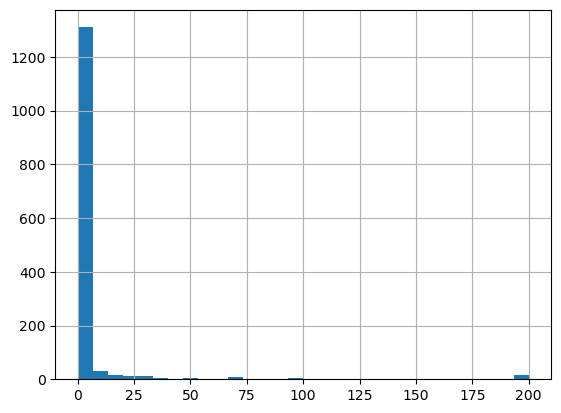

In [150]:
bel_1y['pct_diff'].hist(bins=30)

In [156]:
print(f"{100 * (bel_1y['pct_diff'] < 2).sum() / len(bel_1y):0.2f}% of rows have 12-month rates within 2% of 1-year rates.")
print(f"{100 * ((bel_1y['pct_diff'] > 2) & (bel_1y['bel_1y'] < 0.)).sum() / (bel_1y['pct_diff'] > 2).sum():0.2f}% of rows with pct_diff over 2% have negative 1-year rates.")

88.75% of rows have 12-month rates within 2% of 1-year rates.
100.00% of rows with pct_diff over 2% have negative 1-year rates.


So 12-month money market bonds are not always the same value as 1-year, but only when the rates are negative.

# Compute Yield Curves 

# Scratch

In [132]:
# [
#     get_yc(f'YC/{country}3Y', start_date=start_date, end_date=end_date, col_prefix=country.lower())
#     for country in ('PAK',)
# ][0]